In [87]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

## Question 1

In [42]:
with open('logins.json') as f:
  logins = json.load(f)

logins = pd.DataFrame([logins['login_time']][0])
logins[0] =  pd.to_datetime(logins[0], format= '%Y-%m-%d %H:%M:%S')
logins.set_index(logins[0], inplace =True)
logins = logins.resample('15T').count()
logins1 = logins.resample('1D').mean()
logins.columns = ['count']
logins1.columns = ['count']

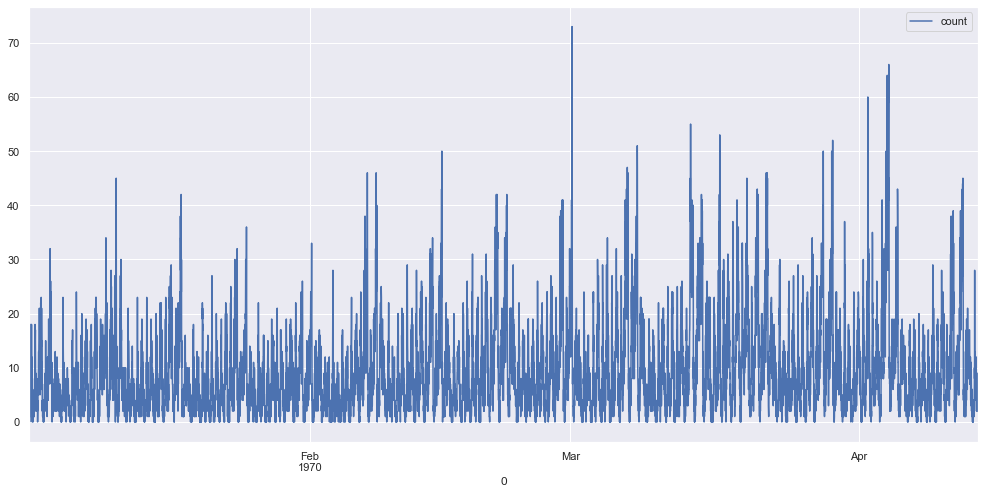

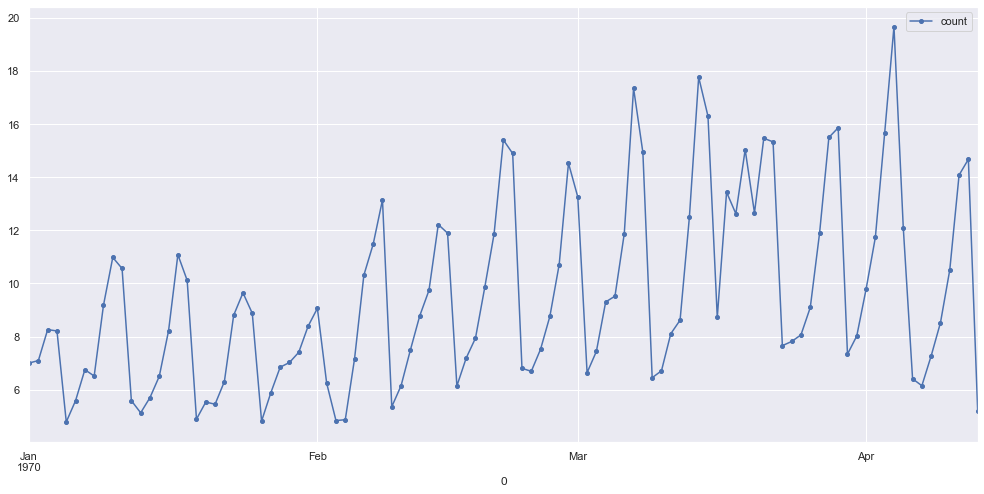

In [43]:
sns.set(rc={'figure.figsize':(17, 8)})
logins.plot(markersize=2)
logins1.plot(markersize = 8, marker='.')

There appear to be cycles in the data. It appears as though the company is very useful during weekends or certain other high times of the weeks, but has an intrinsic cyclical nature.



Text(0, 0.5, 'Frequency')

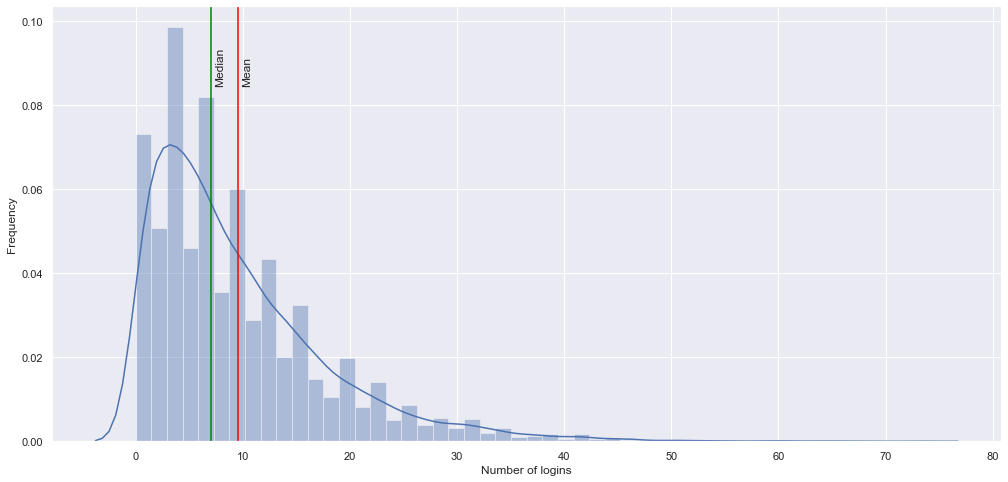

In [92]:
sns.distplot(logins)
plt.axvline(np.mean(logins['count']), color = 'red')
plt.text(np.mean(logins['count'])+0.45, 0.085,'Mean',rotation=90)
plt.axvline(np.median(logins['count']), color = 'green')
plt.text(np.median(logins['count'])+0.45, 0.085,'Median',rotation=90)
plt.xlabel('Number of logins')
plt.ylabel('Frequency')

Text(0.5, 0, 'Number of logins')

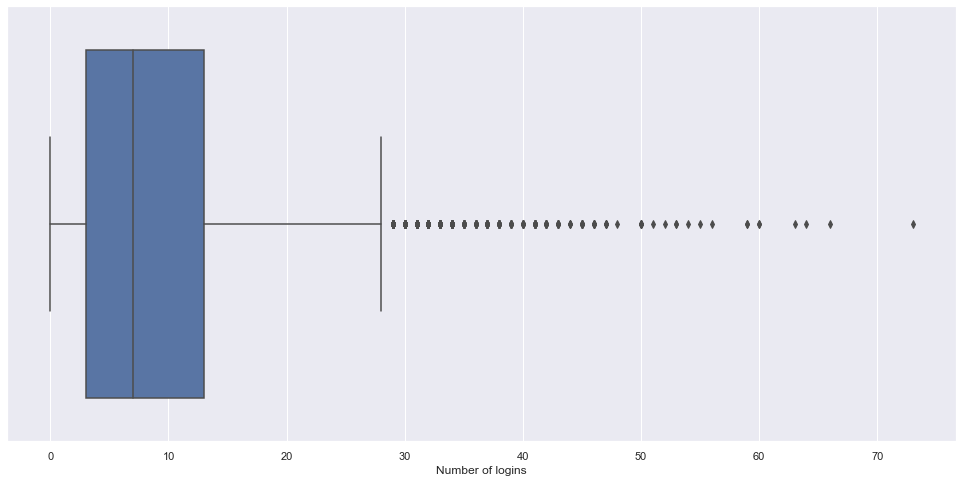

In [94]:
sns.boxplot(logins)
plt.xlabel('Number of logins')

It looks like the ridership is skewed right highly. A few people use the app a lot and many use it only about 10 times. Please see the grapsh for further details. This is useful information when working with this data because it will pop up again if we were to model this data.

Also, there don't seem to be any intrinsic data issues.

## Question 2

1. The fundamental metric that I would choose is the count of customers services by each driver in each city. This itself contains a lot of information, but can easily be converted to a % of Gotham clients for each driver. Ideally in the context of this problem, the % would be close to zero.

2. I would set up an A/B test reimbursing a random 50% of drivers for their tolls. This way I would have one control group and one experimental group. The groups would get assigned at the beginning of the experiment and drivers would not be able to switch groups for the duration of the experiment.

Considering that tolls work 24 hours per day and on the weekends, the differences in the circadian rythms should not be a big factor in this experiment. We would expect the busier times in both cities to have a closer to an even split of drivers in the group that got the offer to get their tolls reimbursed. The issue is even less present during the weekend when the activity levels of both cities are similar.


a. I would get a representative sample of the whole population, depending on the details of the experiment, this might be the whole population. I would then split it into two equal groups, one of which will receive the offer of reimbursed tolls, and the other would not. I may not get 50% buy-in off the bat, so I will keep increasing the amount of people I send the offer to until the two groups are roughly equal in size. From there I will 'freeze' the groups, meaning no member can become a member of the other group for the duration of the experiment. I would then record the key metric per day for each driver; the key metric being % of customers from Gotham.

b. I would do a 10000 size bootstrap 95% CI for the difference of means of the % of customers from Gotham for both groups. At this large a bootstrap sample, I would compare the means of the two groups. If the difference of means CI includes 0 in its range, then the offer doesn't work, at least at this time. If it doesn't include 0, then we can conclude that at this time in the year, there is a significant difference. 

c. The biggest caveat with a test like this is that if it's not carried out over the course of a whole year, we may not get an idea of how the results change each season. To account for this, we might have to run a year long experiment, or increase the confidence of the test to 99%. This implies getting more data through a larger sample, or at least acquiring the data for a longer period of time. 

Of course events such as natural catastrophies, big changes in other policy, sudden spikes in crime, terrorist acts, etc. will also have an impact on the model, and it will unlikely be useful during those times.

# Question 3

In [47]:
with open('ultimate_data_challenge.json') as f:
  data = json.load(f)

In [48]:
data

[{'city': "King's Landing",
  'trips_in_first_30_days': 4,
  'signup_date': '2014-01-25',
  'avg_rating_of_driver': 4.7,
  'avg_surge': 1.1,
  'last_trip_date': '2014-06-17',
  'phone': 'iPhone',
  'surge_pct': 15.4,
  'ultimate_black_user': True,
  'weekday_pct': 46.2,
  'avg_dist': 3.67,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 0,
  'signup_date': '2014-01-29',
  'avg_rating_of_driver': 5.0,
  'avg_surge': 1.0,
  'last_trip_date': '2014-05-05',
  'phone': 'Android',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 50.0,
  'avg_dist': 8.26,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 3,
  'signup_date': '2014-01-06',
  'avg_rating_of_driver': 4.3,
  'avg_surge': 1.0,
  'last_trip_date': '2014-01-07',
  'phone': 'iPhone',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 100.0,
  'avg_dist': 0.77,
  'avg_rating_by_driver': 5.0},
 {'city': "King's Landing",
  'trips_in_fir

In [49]:
data = json_normalize(data)

In [50]:
data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [51]:
max(data['last_trip_date'])

'2014-07-01'

In [52]:
for col in data.columns:
    if data[col].isnull().values.sum() > 0:
        print(col, ":", data[col].isnull().values.sum(), 'missing values.')

avg_rating_of_driver : 8122 missing values.
phone : 396 missing values.
avg_rating_by_driver : 201 missing values.


One categorical variable has missing values: phone. I will impute this with the most used phone. There aren't many missing values, so I will not worry about this method's impact on the model.

There are ratings missing from the driver and customer side. I will impute this with the median value, with the thinking that if a person didn't rate the other person, then they likely didn't feel strongly one way or the other.

In [53]:
#filling in NA's
data['avg_rating_of_driver'].fillna((data['avg_rating_of_driver'].mean()), inplace=True)
data['avg_rating_by_driver'].fillna((data['avg_rating_by_driver'].mean()), inplace=True)
data['phone'].fillna(("iPhone"), inplace = True)

### Was the customer retained?

My thinking here is if the user has been retained for 5 months or 20 weeks, then they will likely stay for at least another month. Because the data that we have was gathered before the 6 month timeframe for each user, I have to make the assumption that if they stayed for 5 months and were happy with the service, they will stay for more.

In [54]:
data['new_date'] = pd.to_datetime(data['signup_date'], format= '%Y-%m-%d') + pd._libs.tslibs.timedeltas.Timedelta(weeks=20)  

In [59]:
data['retained'] = (data['new_date'] < pd.to_datetime(data['last_trip_date'], format= '%Y-%m-%d')).astype(int)

In [60]:
data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,new_date,retained
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-14,1
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-06-18,0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-05-26,0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-05-30,1
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-06-16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,2014-06-14,0
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,2014-06-13,0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,2014-06-20,0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,2014-06-03,0


In [82]:
np.mean(data['retained'])

0.3354

Even though this is a classification task, I will not be using any linear methods. The reason for this is that out of 50000 users, only 16770 stayed for 5 months. This means that the two gorups are not equal in size, which will harm the predictive ability of linear based models.

### Modeling

I will limit my modeling to Random Forests for the sake of the assignment as it is a versitile method that, with proper CV, doesn't overfit badly and is responsive to new data. Given more time to train and tune, models such as SVMs, or XGBoost might also produce good results. But for the sake of brevity, I will be going with a RF, even though the methodology to tune the models would be analogous to all of them. I should also emphasize again that because of the uneven split between the retained customers and the lsot customers, logistic regression might not do well.

In [62]:
#getting rid of values that will be useless in modeling:

data.drop(['signup_date', 'last_trip_date', 'new_date'], axis = 1, inplace = True)

In [63]:
data

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.700000,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.000000,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.300000,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.600000,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.400000,1.19,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,5.000000,1.00,iPhone,0.0,False,100.0,5.63,4.2,0
49996,Astapor,1,4.601559,1.00,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,5.000000,1.00,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,3.000000,1.00,iPhone,0.0,False,100.0,4.58,3.5,0


In [64]:
data = pd.get_dummies(data, columns = ['city', 'phone', 'ultimate_black_user'], drop_first = True)

In [74]:
data

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.700000,1.10,15.4,46.2,3.67,5.0,1,1,0,1,1
1,0,5.000000,1.00,0.0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.300000,1.00,0.0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.600000,1.14,20.0,80.0,2.36,4.9,1,1,0,1,1
4,14,4.400000,1.19,11.8,82.4,3.13,4.9,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,100.0,5.63,4.2,0,1,0,1,0
49996,1,4.601559,1.00,0.0,0.0,0.00,4.0,0,0,0,1,0
49997,0,5.000000,1.00,0.0,100.0,3.86,5.0,0,0,1,0,1
49998,2,3.000000,1.00,0.0,100.0,4.58,3.5,0,0,0,1,0


In [79]:
# help from datacamp

y = data.loc[:,'retained']
x = data.drop('retained', axis = 1)

# Split into training and test set
# Stratifying to make sure the split of phisihng/valid stays equal across train/test split.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=2, stratify=y)

In [80]:
# Making sure stratifying worked.
np.mean(y_train), np.mean(y_test)

(0.3354, 0.3354)

### RF

In [83]:
#datacamp
params_rf = {
             'n_estimators': [100, 350, 500],
             'max_features': ['log2', 'auto', 'sqrt'],
             'min_samples_leaf': [2, 10, 30], 
             }

In [84]:
#datacamp
# Instantiate rf
rf = RandomForestClassifier(random_state=2)


In [85]:
#datacamp

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='roc_auc',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

grid_rf.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  2.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=2,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [88]:
#datacamp

# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(x_test)

# Compute roc_auc
roc_auc = roc_auc_score(y_test, y_pred)

# Print roc_auc
print('Test ROC_AUC of best model: {:.3f}'.format(roc_auc))

Test ROC_AUC of best model: 0.729


In [90]:
feature_coef = pd.DataFrame(best_model.feature_importances_).transpose()
feature_coef.columns = list(x_train.columns)
feature_coef.index = ['RF'] 
feature_coef.transpose().sort_values(by='RF',ascending=False).head(20)

,RF
avg_rating_by_driver,0.179625
surge_pct,0.149342
weekday_pct,0.141656
avg_dist,0.102383
city_King's Landing,0.096363
avg_surge,0.094977
trips_in_first_30_days,0.071260
phone_iPhone,0.057475
ultimate_black_user_True,0.045591
avg_rating_of_driver,0.045373


3. Judging by the most important factors in the model, it looks like the opinion of the driver's matters most in deciding whether the user will be retained. Further investigation by the company is necessary. This may mean that those who the drivers grade highly are the users who use the service a lot and thus act in a manner that the driver appreciates. weekday-pct and surge-pct are important factors too. The company should focus their attention on the customers who use the surge option and are weekday riders (although it's possible these variables are important because of the small percentages, but this is unlikely). From these insights, the company should look into increasing the ridership and making the service more comfortable and useful for weekday riders and those who are likely to use the surge option.